# 1. Packages

In [48]:
# --- Core data handling
import pandas as pd 
import numpy as np 
import pyarrow

# --- Visualizations
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go 

# --- Statistics and Modeling
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce

# --- File I/O & utilities
import openpyxl
from datetime import datetime

# 2. Data information

In [49]:
df = pd.read_csv ("games.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# 3. Data cleaning and preparation

### 🧹 Data Preparation and Cleaning

During this stage, the dataset was cleaned and standardized to ensure that all columns had the proper format for analysis and that only relevant records remained.

First, all column names were cleaned by removing extra spaces and converting them to lowercase. This provided a consistent and easy-to-use naming convention throughout the project.

Next, the **year_of_release** column was converted from *float* to *integer* (`Int64`). Since years should not appear with decimal values, this step ensured that each year was represented correctly while still allowing missing entries to remain as null values.

The **user_score** column contained some non-numeric entries such as “TBD” (To Be Determined), which indicate that a user score had not yet been assigned. These values were replaced with missing values (`NaN`), and the column was then converted to a numeric format. This allows mathematical and statistical operations to be performed safely on user scores.

Similarly, the **rating** column, which represents the ESRB classification of each game, had missing values that were replaced with the word **“Unknown.”** This ensures that games without an official rating can still be included in summaries and visualizations without producing errors.

After standardizing column formats, rows missing critical information such as the **game name** or **genre** were removed. Records without these attributes cannot contribute meaningful insights to the analysis, as they cannot be identified or categorized by type.

To maintain data integrity, duplicate entries were also removed based on the combination of **name** and **platform**, keeping only the first occurrence of each unique pair. Additionally, games missing the **year_of_release** were dropped since the release year is essential for studying temporal trends and forecasting.

Finally, a new column called **total_sales** was created by summing the regional sales across **North America, Europe, Japan, and Other regions.** This provides a unified measure of each game’s overall commercial performance and will be used extensively in the exploratory and comparative analyses.

Through these transformations, the dataset is now clean, consistent, and fully ready for exploratory data analysis, ensuring that all future findings are based on reliable and well-structured information.


In [50]:
# Columnns standardization and cleaning
df.columns = df.columns.str.strip().str.lower()

# Convert release year to integer, keeping NaN for missing entries 
df["year_of_release"] = (
    pd.to_numeric (df["year_of_release"], errors="coerce")
    .round()
    .astype ("Int64")
)

# Replace 'tbd' with NaN and convert user_score to numeric
us = df["user_score"].astype (str).str.strip().str.lower()
us = us.replace ({"tbd": np.nan})
df["user_score"] = pd.to_numeric (us, errors="coerce")

# Replace NaN in rating with 'unknown'
df["rating"] = df["rating"].replace (np.nan, "unknown")


# Remove games without name and genre
df = df.dropna (subset=["name", "genre"])

# Remove duplicates based on name and platform, keeping the first occurrence
df = df.drop_duplicates (subset=["name", "platform"], keep="first") 

# Remove missing values in year_of_release
df = df.dropna (subset = ["year_of_release"])

# Remove outlier value for DS platform since it doesn't make sense

df = df[~((df["platform"] == "DS") & (df["year_of_release"] < 2004))]

# Create a new column for total sales
df["total_sales"] = df[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum (axis=1)



# 3. EDA

### 3.1 Distribution and Trends (Year, Platforms, Genre)

In [51]:
# Yearly total sales and games count 
sales_by_year = (
    df.groupby("year_of_release", as_index=False)
    .agg (total_sales = ("total_sales", "sum"), 
          games_count = ("name", "count"))
          .sort_values ("year_of_release")
)

# Yearly sales by platform 

sales_platform_year = (
    df.groupby (["platform", "year_of_release"], as_index= False)
    .agg (total_sales = ("total_sales", "sum"))
)

#Platform totals
platform_sales = (
    df.groupby ("platform", as_index = False)
    .agg (total_sales = ("total_sales", "sum"), 
          games_count = ("name", "count"))
          .sort_values ("total_sales", ascending= False)
)

# Genre totals 
genre_sales = (
    df.groupby ("genre", as_index= False).
    agg (total_sales = ("total_sales", "sum"), 
         games_count = ("name", "count"))
         .sort_values ("total_sales", ascending= False)
)

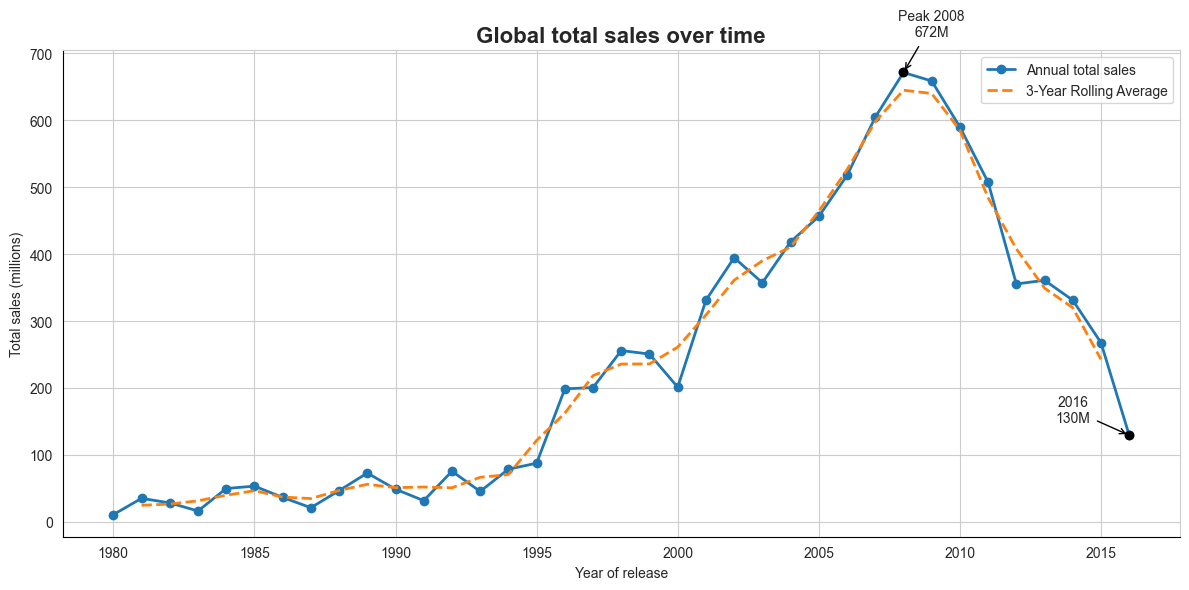

In [52]:
# Visualization: Global total sales over time
sales_by_year ["roll3"]= sales_by_year["total_sales"].rolling (3, center= True).mean()

sns.set_style ("whitegrid")
plt.figure (figsize = (12, 6))

# Main line
plt.plot (
    sales_by_year["year_of_release"], 
    sales_by_year["total_sales"], 
    marker = "o", linewidth=2, label= "Annual total sales"
)

# Smoothed line
plt.plot (
    sales_by_year["year_of_release"], 
    sales_by_year["roll3"], 
    linewidth=2, linestyle= "dashed", label= "3-Year Rolling Average"
)

# Annotate peak and last year 
peak_idx = sales_by_year["total_sales"].idxmax()
peak_year = int(sales_by_year.loc[peak_idx, "year_of_release"])
peak_val = sales_by_year.loc[peak_idx, "total_sales"]

last_year = int(sales_by_year["year_of_release"].iloc[-1])
last_val = sales_by_year["total_sales"].iloc[-1]

# Highlight peak point
plt.scatter ([peak_year], [peak_val], color="black", zorder= 3)

plt.annotate (f"Peak {peak_year}\n{peak_val:,.0f}M",
              xy= (peak_year, peak_val), 
              xytext= (peak_year+1, peak_val*1.08),
              arrowprops=dict (arrowstyle= "->", lw= 1, color="black"),
              fontsize=10, ha="center",
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Highlight last year point
plt.scatter ([last_year], [last_val], color="black", zorder= 3)

plt.annotate (f"{last_year}\n{last_val:,.0f}M",
              xy= (last_year, last_val), 
              xytext= (last_year-2, last_val*1.15),
              arrowprops= dict (arrowstyle= "->", lw= 1, color="black"),
              fontsize=10, ha="center",
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.title ("Global total sales over time", fontsize= 16, weight= "bold")
plt.xlabel ("Year of release")
plt.ylabel ("Total sales (millions)")
plt.gca ().yaxis.set_major_formatter (FuncFormatter (lambda x,_: f"{x:,.0f}"))

# Make axis lines (spines) black
ax = plt.gca()
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")

plt.legend ()
plt.tight_layout ()
plt.show ()

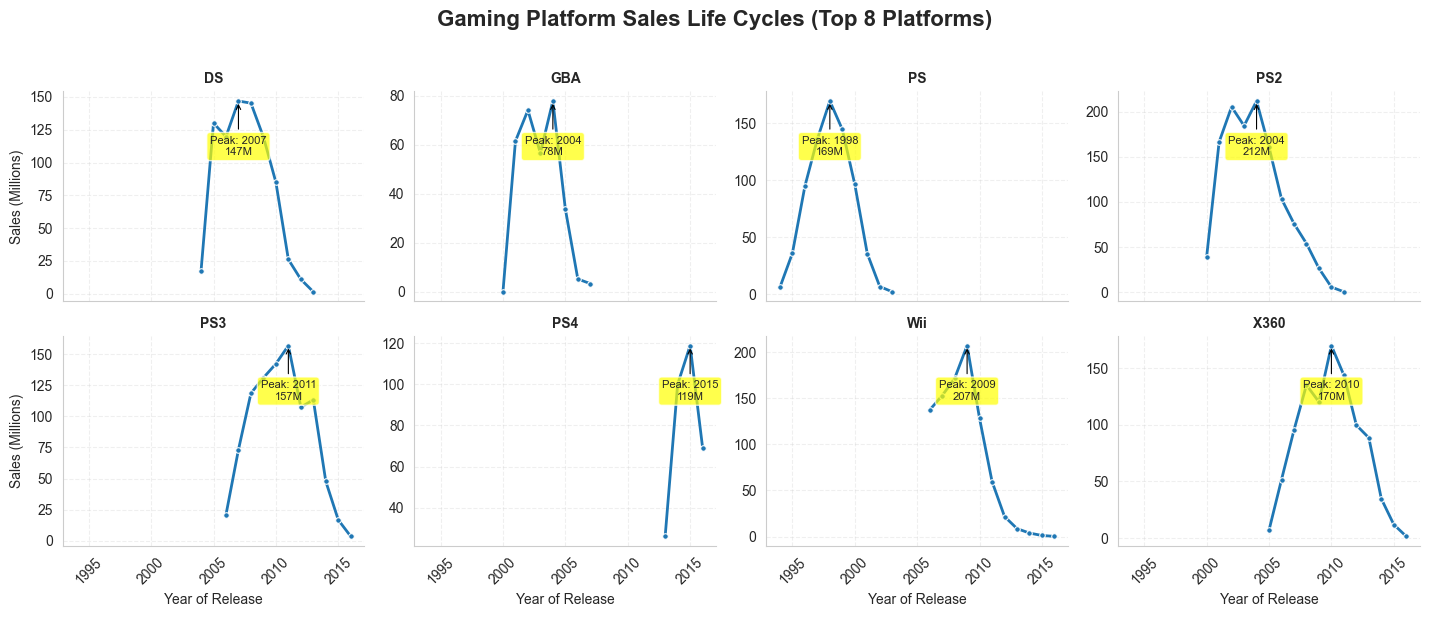

In [57]:
# Yearly sales by platform

# Filter to show only the most relevant platforms (top 8 by total sales)
top_platforms = platform_sales.head(8)["platform"].tolist()
sales_platform_year_filtered = sales_platform_year[
    sales_platform_year["platform"].isin(top_platforms)
]

# Create the improved visualization
g = sns.FacetGrid (
    sales_platform_year_filtered, 
    col = "platform", 
    col_wrap= 4,
    sharey = False, 
    height = 3,
    aspect = 1.2
)

# Map the line plot with better styling
g.map (sns.lineplot, "year_of_release", "total_sales", 
       marker = "o", linewidth = 2, markersize = 4)

# Improve titles and formatting
g.set_titles ("{col_name}", fontsize = 12, fontweight = "bold")
g.fig.suptitle ("Gaming Platform Sales Life Cycles (Top 8 Platforms)", 
                fontsize = 16, fontweight = "bold", y = 1.02)

# Add axis labels and formatting
g.set_axis_labels("Year of Release", "Sales (Millions)")

# Format y-axis to show values in millions with commas
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.tick_params(axis="x", rotation=45)
    
    # Add subtle grid for better readability
    ax.grid(True, alpha=0.3, linestyle="--")
    
    # Highlight peak year for each platform
    platform_data = sales_platform_year_filtered[
        sales_platform_year_filtered["platform"] == ax.get_title()
    ]
    if not platform_data.empty:
        peak_idx = platform_data["total_sales"].idxmax()
        peak_year = platform_data.loc[peak_idx, "year_of_release"]
        peak_sales = platform_data.loc[peak_idx, "total_sales"]
        
        # Add peak annotation if sales are significant
        if peak_sales > 10:  # Only annotate if peak sales > 10M
            
            # Smart positioning to avoid title overlap
            y_max = ax.get_ylim()[1]
            y_pos_ratio = peak_sales / y_max
            
            # If peak is in upper portion of chart, place annotation below
            if y_pos_ratio > 0.7:
                xytext_offset = (0, -25)
                va_align = "top"
            else:
                xytext_offset = (0, 15)
                va_align = "bottom"
            
            ax.annotate(f"Peak: {peak_year}\n{peak_sales:.0f}M",
                       xy=(peak_year, peak_sales),
                       xytext=xytext_offset, textcoords="offset points",
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                       fontsize=8, ha="center", va=va_align,
                       arrowprops=dict(arrowstyle="->", color="black", lw=0.8))

plt.tight_layout()
plt.show()